# Neuropixel SpikeInterface pipelne

**Created by Shun Li @ 2023/05/17, modified for Paolo**

Outline is from SpikeInterface tutorial

## Import files and packages

In [2]:
from ipyfilechooser import FileChooser

fc = FileChooser('D:/Shun/Recordings')
display(fc)

FileChooser(path='D:\Shun\Recordings', filename='', title='', show_hidden=False, select_desc='Select', change_…

In [3]:
%matplotlib inline

import spikeinterface.full as si

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns

In [4]:
spikeglx_folder = fc.selected_path
base_folder = Path(spikeglx_folder)
spikeglx_folder

'D:\\Shun\\Recordings\\Ephys\\20230613-SL091-EP-test_g0'

## Read the data

The SpikeGLX folder can contain several “streams” (AP, LF and NIDQ). We need to specify which one to read:

In [5]:
stream_names, stream_ids = si.get_neo_streams('plexon', spikeglx_folder)
stream_names

['imec0.ap', 'nidq', 'imec0.lf']

In [6]:
# we do not load the sync channel, so the probe is automatically loaded
raw_rec = si.read_plexon(spikeglx_folder, stream_name='imec0.ap', load_sync_channel=False)
raw_rec

SpikeGLXRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 2341.561s

In [8]:
# # we automaticaly have the probe loaded!
# raw_rec.get_probe().to_dataframe()

(700.0, 2200.0)

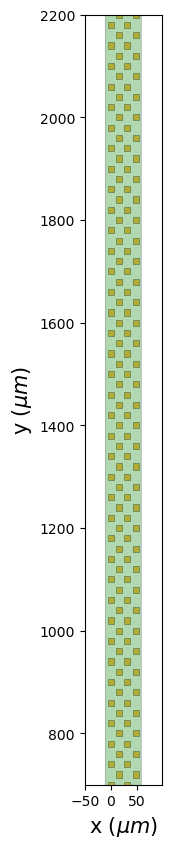

In [7]:
# Set ylim for probe view
probe_ylower = 700
probe_yupper = 2200

fig, ax = plt.subplots(figsize=(15, 10))
si.plot_probe_map(raw_rec, ax=ax, with_channel_ids=False)
ax.set_ylim(probe_ylower, probe_yupper)

## Slice/concatenate files

In [12]:
# %matplotlib widget
# si.plot_timeseries(raw_rec, backend='ipywidgets')

## Preprocessing

Let’s do something similar to the IBL destriping chain (See :ref:`ibl_destripe`) to preprocess the data but:

- instead of interpolating bad channels, we remove them

- instead of highpass_spatial_filter() we use common_reference()

In [ ]:
# # Remove artifact
# rec_clean = remove_artifacts(raw_rec, list_triggers)

In [8]:
# High pass filter
rec1 = si.highpass_filter(raw_rec, freq_min=300.)

# Phase shift
rec2 = si.phase_shift(rec1)

# Remove bad channels
bad_channel_ids, channel_labels = si.detect_bad_channels(rec2)
# rec3 = rec2.remove_channels(bad_channel_ids)
rec3 = si.interpolate_bad_channels(rec2, bad_channel_ids)
print('bad_channel_ids', bad_channel_ids)

# CAR
rec4 = si.common_reference(rec3, operator="median", reference="global")
rec = rec4
rec

# Destriping (need to split by group)
# rec = si.highpass_spatial_filter(rec3)

bad_channel_ids ['imec0.ap#AP191']


CommonReferenceRecording: 384 channels - 1 segments - 30.0kHz - 2341.561s

### Plot preprocess results

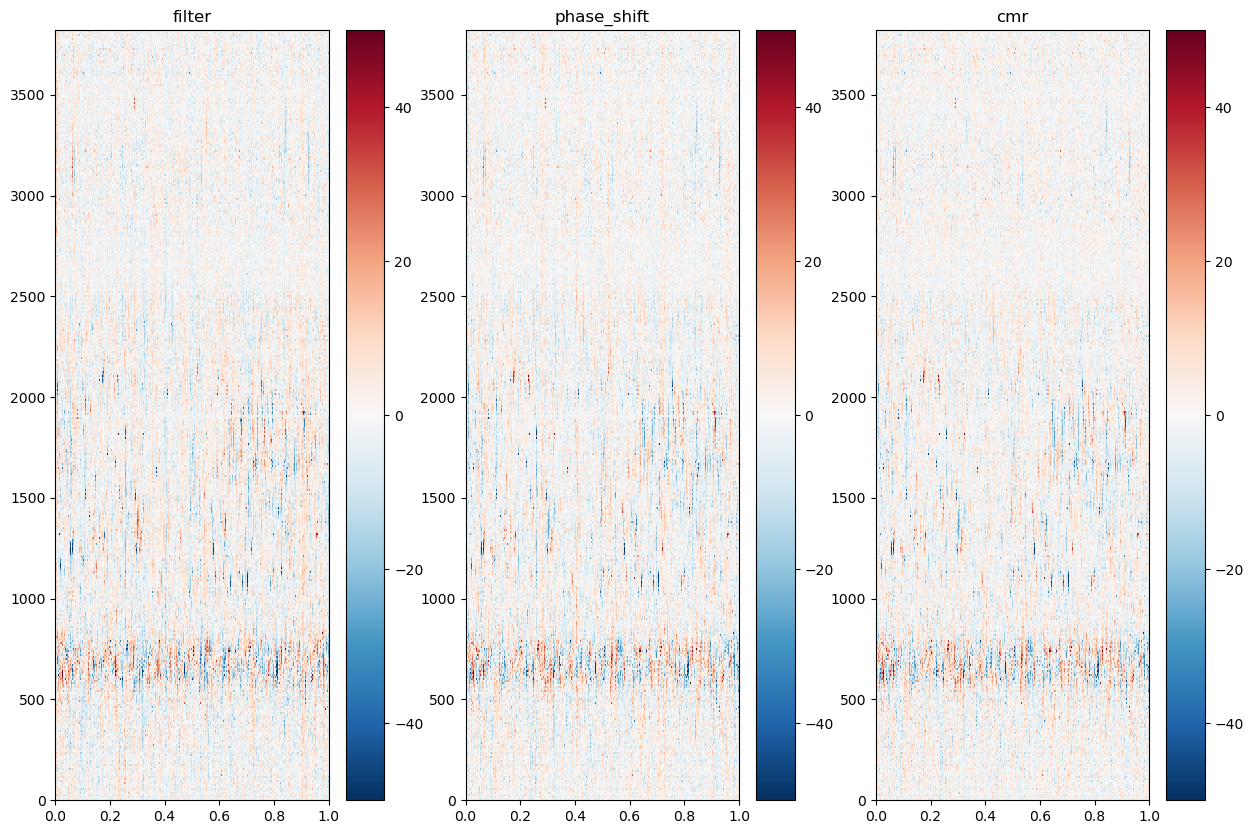

In [9]:
# here we use static plot using matplotlib backend
fig, axs = plt.subplots(ncols=3, figsize=(15, 10))

si.plot_timeseries(rec1, backend='matplotlib',  clim=(-50, 50), ax=axs[0])
si.plot_timeseries(rec2, backend='matplotlib',  clim=(-50, 50), ax=axs[1])
si.plot_timeseries(rec, backend='matplotlib',  clim=(-50, 50), ax=axs[2])
for i, label in enumerate(('filter', 'phase_shift', 'cmr')):
    axs[i].set_title(label)

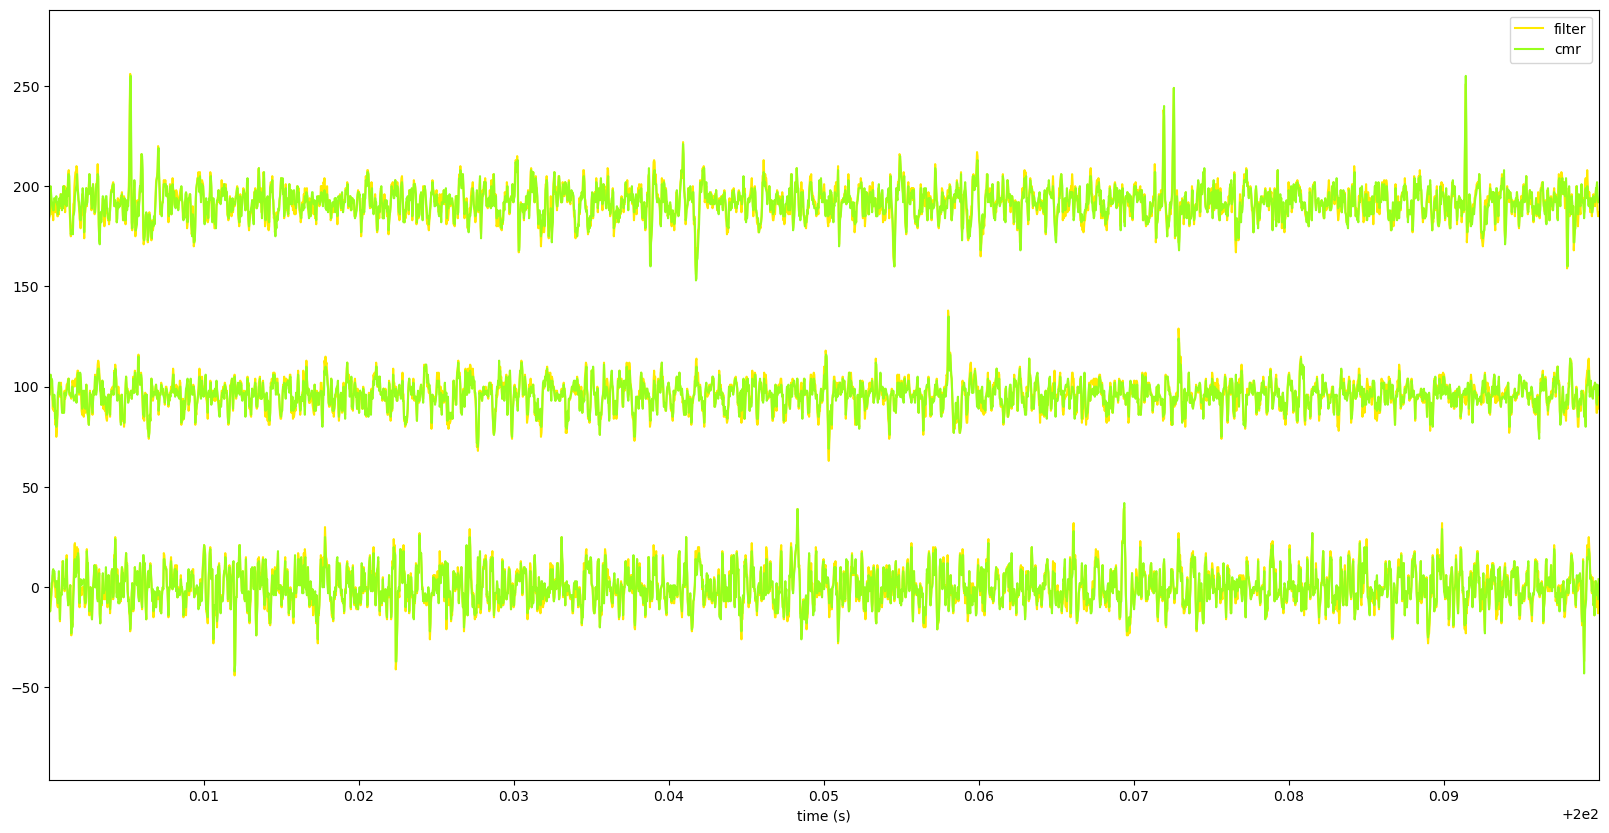

In [9]:
# plot some channels
fig, ax = plt.subplots(figsize=(20, 10))
some_chans = rec.channel_ids[[50, 100, 200, ]]
si.plot_timeseries({'filter':rec1, 'cmr': rec4}, time_range=[200,200.1],
                   backend='matplotlib', mode='line', ax=ax, channel_ids=some_chans)

### Save preprocessed data into a binary file
Depending on the machine, the I/O speed, and the number of times we will need to “use” the preprocessed recording, we can decide whether it is convenient to save the preprocessed recording to a file.

Saving is not necessarily a good choice, as it consumes a lot of disk space and sometimes the writing to disk can be slower than recomputing the preprocessing chain on-the-fly.

Here, we decide to do save it because Kilosort requires a binary file as input, so the preprocessed recording will need to be saved at some point.

Depending on the complexity of the preprocessing chain, this operation can take a while. However, we can make use of the powerful parallelization mechanism of SpikeInterface.

In [11]:
job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)

rec = rec.save(folder=base_folder / 'preprocess', format='binary', **job_kwargs)
# our recording now points to the new binary folder
rec

write_binary_recording with n_jobs = 40 and chunk_size = 30000


write_binary_recording:   0%|          | 0/2342 [00:00<?, ?it/s]

BinaryFolderRecording: 384 channels - 1 segments - 30.0kHz - 2341.561s

## Quality checks before spike sorting

A good practice before running a spike sorter is to check the “peaks activity” and the presence of drifts.

SpikeInterface has several tools to:

- estimate the noise levels

- detect peaks (prior to sorting)

- estimate positions of peaks

### Check noise level

In [10]:
# we can estimate the noise on the scaled traces (microV) or on the raw one (which is in our case int16).
noise_levels_microV = si.get_noise_levels(rec, return_scaled=True)
noise_levels_int16 = si.get_noise_levels(rec, return_scaled=False)

### Detect and localize peaks

SpikeInterface includes built-in algorithms to detect peaks and also to localize their position. This is part of the sortingcomponents module and needs to be imported explicitly.

The two functions (detect + localize):
- can be run parallel
- are very fast when the preprocessed recording is already saved (and a bit slower otherwise)
- implement several methods

Here we use the `locally_exclusive` method for detection and the `center_of_mass` for peak localization:

In [12]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
peaks = detect_peaks(rec,  method='locally_exclusive', noise_levels=noise_levels_int16,
                     detect_threshold=5, local_radius_um=50., **job_kwargs)
peaks

detect peaks:   0%|          | 0/2342 [00:00<?, ?it/s]

array([(       2, 156, -35., 0), (       5, 132, -66., 0),
       (       7, 113, -39., 0), ..., (70246808, 244, -26., 0),
       (70246810,  53, -95., 0), (70246821, 268, -16., 0)],
      dtype=[('sample_ind', '<i8'), ('channel_ind', '<i8'), ('amplitude', '<f8'), ('segment_ind', '<i8')])

In [13]:
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

peak_locations = localize_peaks(rec, peaks, method='center_of_mass', local_radius_um=50., **job_kwargs)

localize peaks:   0%|          | 0/2342 [00:00<?, ?it/s]

### Check for drifts

We can manually check for drifts with a simple scatter plots of peak times VS estimated peak depths.

In case we notice apparent drifts in the recording, one can use the SpikeInterface modules to estimate and correct motion. See the documentation for motion estimation and correction for more details.

In [25]:
# # check for drifts
# fs = rec.sampling_frequency
# fig, ax = plt.subplots(figsize=(10, 8))
# ax.scatter(peaks['sample_ind'] / fs, peak_locations['y'], color='k', marker='.',  alpha=0.002)

### Plot summary plot

NameError: name 'noise_levels_microV' is not defined

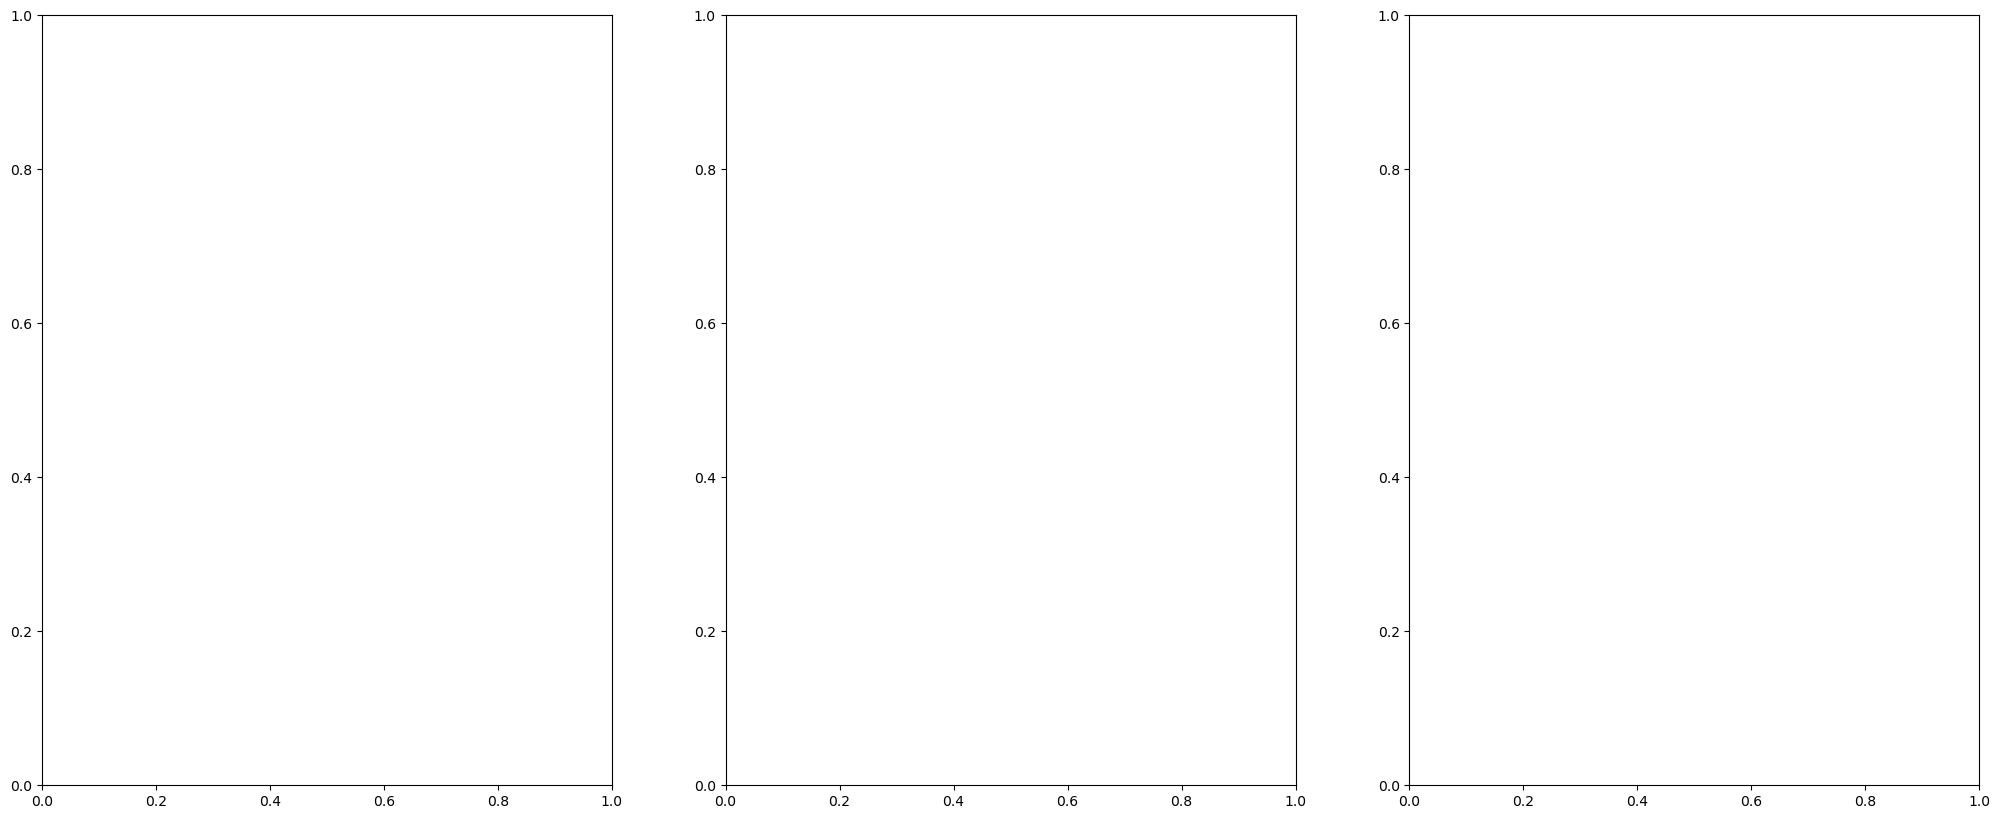

In [12]:
fig, axs = plt.subplots(ncols=3,figsize=(25,10))

# Plot noise level
_ = axs[0].hist(noise_levels_microV, bins=np.arange(5, 30, 2.5))
axs[0].set_xlabel('noise  [microV]')
axs[0].set_ylabel('Occurance (a.u.)')

# Plot drifts
fs = rec.sampling_frequency
axs[1].scatter(peaks['sample_ind'] / fs, peak_locations['y'], color='k', marker='.',  alpha=0.002)

# we can also use the peak location estimates to have an insight of cluster separation before sorting
# Set ylim for probe view
probe_ylower = 700
probe_yupper = 2200

si.plot_probe_map(rec, ax=axs[2], with_channel_ids=False)
axs[2].set_ylim(probe_ylower, probe_yupper)
axs[2].scatter(peak_locations['x'], peak_locations['y'], color='purple', alpha=0.002)

plt.savefig(base_folder / 'recording_summary.png')

## Run a spike sorter

Even if running spike sorting is probably the most critical part of the pipeline, in SpikeInterface this is dead-simple: one function.

Important notes:
- most of sorters are wrapped from external tools (kilosort, kisolort2.5, spykingcircus, montainsort4 …) that often also need other requirements (e.g., MATLAB, CUDA)
- some sorters are internally developed (spyekingcircus2)
- external sorter can be run inside a container (docker, singularity) WITHOUT pre-installation

Please carwfully read the `spikeinterface.sorters` documentation for more information.

In [11]:
# Set kilosort 2.5 path
kilosort2_5_path = f'C:/Users/sabatini/Documents/SpikeInterface/Kilosort-2.5'
pykilosort_path = f'C:/Users/sabatini/Documents/SpikeInterface/pykilosort'
si.Kilosort2_5Sorter.set_kilosort2_5_path(kilosort2_5_path)
# si.Kilosort2_5Sorter.set_kilosort2_5_path(kilosort2_5_path)

si.installed_sorters()

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: C:\Users\sabatini\Documents\SpikeInterface\Kilosort-2.5


['kilosort2_5', 'spykingcircus2', 'tridesclous', 'tridesclous2']

### Run multiple sorters in parallel

In [13]:
sorter_list = ['tridesclous', 'spykingcircus2']
sorter_params = {
    'tridesculous':{'detect_threshold':5.}
}
sorting_output = si.run_sorters(sorter_list, [rec], working_folder=base_folder / 'multi-sorter_output',
                             mode_if_folder_exists='keep',sorter_params=sorter_params)

# the output is a dict with (rec_name, sorter_name) as keys
for (rec_name, sorter_name), sorting in sorting_output.items():
    print(rec_name, sorter_name, ':', sorting.get_unit_ids())

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\Shun\\Recordings\\Ephys\\20230613-SL091-EP-test_g0\\multi-sorter_output\\recording_0\\tridesclous\\sorter_output\\channel_group_0\\catalogue_constructor\\all_peaks.raw'

### Spike sorting as a whole

In [75]:
# check default params for kilosort
# si.get_default_sorter_params('kilosort2_5')

In [51]:
# Sorting as a whole
sorting = si.run_sorter('kilosort2_5', rec, output_folder=base_folder / 'kilosort2.5_output',
                        do_correction=True, docker_image=False, verbose=True)

RUNNING SHELL SCRIPT: D:\Shun\Recordings\Ephys\20221121-SL047-D1_g0\20221121-SL047-D1_g0_imec0\kilosort2.5_output\sorter_output\run_kilosort2_5.bat


(spikeinterface) C:\Users\sabatini\Documents\SpikeInterface>D:



(spikeinterface) D:\>cd D:\Shun\Recordings\Ephys\20221121-SL047-D1_g0\20221121-SL047-D1_g0_imec0\kilosort2.5_output\sorter_output 



(spikeinterface) D:\Shun\Recordings\Ephys\20221121-SL047-D1_g0\20221121-SL047-D1_g0_imec0\kilosort2.5_output\sorter_output>matlab -nosplash -wait -r "kilosort2_5_master('D:\Shun\Recordings\Ephys\20221121-SL047-D1_g0\20221121-SL047-D1_g0_imec0\kilosort2.5_output\sorter_output', 'C:\Users\sabatini\Documents\SpikeInterface\Kilosort-2.5')" 

kilosort2_5 run time 2063.07s


### Spike sorting by groups

Sometimes you may want to spike sort using specific grouping, for example when working with tetrodes, with multi-shank probes, or if the recording has data from different probes. Alternatively, for long silicon probes, such as Neuropixels, one could think of spike sorting different areas separately, for example using a different sorter for the hippocampus, the thalamus, or the cerebellum. Running spike sorting by group is indeed a very common need.

A `BaseRecording` object have the ability to split itself into a dictionary of sub-recordings given a certain property (see `split_by()`). So it is easy to loop over this dictionary and sequentially run spike sorting on these sub-recordings. SpikeInterface also propose a high-level function to automate the process of splitting the recording and then aggregating the result with the `run_sorter_by_property()` function.

For the 4-shank probe, I would spike sort different shank separately. I can use the `ss.run_sorter_by_property()`  instead of the `run_sorter()`  and use `group` as a property (which is automatically loaded for NP2)

In [14]:
# Sorting by groups
sorting = si.run_sorter_by_property('kilosort2_5', rec, do_correction=True,
                                 grouping_property='group', 
                                 working_folder= base_folder/'kilosort2.5_output',
                                 mode_if_folder_exists="keep",
                                 docker_image=False,verbose=True)

write_binary_recording:   0%|          | 0/2600 [00:00<?, ?it/s]

RUNNING SHELL SCRIPT: D:\Shun\Recordings\Ephys\20230516-SL051-Random_g0\kilosort2.5_output\0\kilosort2_5\sorter_output\run_kilosort2_5.bat


(spikeinterface) C:\Users\sabatini\Documents\SpikeInterface>D:



(spikeinterface) D:\>cd D:\Shun\Recordings\Ephys\20230516-SL051-Random_g0\kilosort2.5_output\0\kilosort2_5\sorter_output 



(spikeinterface) D:\Shun\Recordings\Ephys\20230516-SL051-Random_g0\kilosort2.5_output\0\kilosort2_5\sorter_output>matlab -nosplash -wait -r "kilosort2_5_master('D:\Shun\Recordings\Ephys\20230516-SL051-Random_g0\kilosort2.5_output\0\kilosort2_5\sorter_output', 'C:\Users\sabatini\Documents\SpikeInterface\Kilosort-2.5')" 

kilosort2_5 run time 519.21s


write_binary_recording:   0%|          | 0/2600 [00:00<?, ?it/s]

RUNNING SHELL SCRIPT: D:\Shun\Recordings\Ephys\20230516-SL051-Random_g0\kilosort2.5_output\1\kilosort2_5\sorter_output\run_kilosort2_5.bat


(spikeinterface) C:\Users\sabatini\Documents\SpikeInterface>D:



(spikeinterface) D:\>cd D:\Shun\Recordings\Ephys\20230516-SL051-Random_g0\kilosort2.5_output\1\kilosort2_5\sorter_output 



(spikeinterface) D:\Shun\Recordings\Ephys\20230516-SL051-Random_g0\kilosort2.5_output\1\kilosort2_5\sorter_output>matlab -nosplash -wait -r "kilosort2_5_master('D:\Shun\Recordings\Ephys\20230516-SL051-Random_g0\kilosort2.5_output\1\kilosort2_5\sorter_output', 'C:\Users\sabatini\Documents\SpikeInterface\Kilosort-2.5')" 

kilosort2_5 run time 412.89s


write_binary_recording:   0%|          | 0/2600 [00:00<?, ?it/s]

RUNNING SHELL SCRIPT: D:\Shun\Recordings\Ephys\20230516-SL051-Random_g0\kilosort2.5_output\2\kilosort2_5\sorter_output\run_kilosort2_5.bat


(spikeinterface) C:\Users\sabatini\Documents\SpikeInterface>D:



(spikeinterface) D:\>cd D:\Shun\Recordings\Ephys\20230516-SL051-Random_g0\kilosort2.5_output\2\kilosort2_5\sorter_output 



(spikeinterface) D:\Shun\Recordings\Ephys\20230516-SL051-Random_g0\kilosort2.5_output\2\kilosort2_5\sorter_output>matlab -nosplash -wait -r "kilosort2_5_master('D:\Shun\Recordings\Ephys\20230516-SL051-Random_g0\kilosort2.5_output\2\kilosort2_5\sorter_output', 'C:\Users\sabatini\Documents\SpikeInterface\Kilosort-2.5')" 

kilosort2_5 run time 1058.86s


In [45]:
# the results can be read back for future session

shank = 1
sorting = si.read_sorter_folder(base_folder / 'kilosort2.5_output' / str(shank) / 'kilosort2_5')
sorting

KiloSortSortingExtractor: 63 units - 1 segments - 30.0kHz

## Post-processing

All the postprocessing step is based on the `WaveformExtractor` object.

This object combines a `recording` and a `sorting` object and extracts some waveform snippets (500 by default) for each units.

Note that we use the `sparse=True` option. This option is important because the waveforms will be extracted only for a few channels around the main channel of each unit. This saves tons of disk space and speeds up the waveforms extraction and further processing.

### Set storing folder path and determine shank number

In [18]:
job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)

# Figure out how many shank

# Load recording sessions

rec_by_group_dict = raw_rec.split_by("group")
num_shanks = len(rec_by_group_dict)
num_shanks

1

In [24]:
session_sorting_path = base_folder / 'multi-sorter_output'

### Extract waveforms for each shank

In [23]:
# For all shanks
for shank in range(num_shanks):
    print('Extracting waveforms for shank ' + str(shank) + '...')
    shank_path = 'recording_' + str(shank)
    shank_sorting_path = session_sorting_path / shank_path
    
    sorting = si.read_sorter_folder(shank_sorting_path / 'kilosort2_5')
    we = si.extract_waveforms(rec, sorting, folder=shank_sorting_path / 'waveforms_kilosort2_5',
                              sparse=True, max_spikes_per_unit=500, ms_before=1.5,ms_after=2.,
                              **job_kwargs)

Extracting waveforms for shank 0...


extract waveforms shared_memory:   0%|          | 0/2342 [00:00<?, ?it/s]

extract waveforms shared_memory:   0%|          | 0/2342 [00:00<?, ?it/s]

extract waveforms shared_memory:   0%|          | 0/2342 [00:00<?, ?it/s]

extract waveforms shared_memory:   0%|          | 0/2342 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/2342 [00:00<?, ?it/s]

### Load waveforms for each shank and calculate basics params

Many additional computations rely on the `WaveformExtractor`. Some computations are slower than others, but can be performed in parallel using the `**job_kwargs` mechanism. Every computation will also be persistent on disk in the same folder, since they represent waveform extensions.

In [58]:
# Load all shanks
for shank in range(num_shanks):
    # Load waveforms
    print('Loading waveforms for shank ' + str(shank) + '...')
    shank_path = 'recording_' + str(shank)
    shank_sorting_path = session_sorting_path / shank_path
    shank_wf_path = shank_sorting_path / 'waveforms_kilosort2_5'
    we = si.load_waveforms(shank_wf_path)
    
    # Calculate essential params (listed in tutorial notebook in spikeinterface)
    _ = si.compute_noise_levels(we)
    _ = si.compute_correlograms(we)
    _ = si.compute_isi_histograms(we)
    _ = si.compute_unit_locations(we)
    _ = si.compute_template_similarity(we)
    _ = si.compute_spike_amplitudes(we, **job_kwargs)
    
    # Calculate optional params (not listed in notebook)
    _ = si.compute_template_metrics(we)
    _ = si.compute_spike_locations(we, **job_kwargs)
    _ = si.compute_principal_components(we, **job_kwargs)

Loading waveforms for shank 0...


C:\Users\sabatini\.conda\envs\spikeinterface\lib\site-packages\spikeinterface\postprocessing\unit_localization.py:315: RuntimeWarning: invalid value encountered in true_divide
  com = np.sum(wf_ptp[:, np.newaxis] * local_contact_locations, axis=0) / np.sum(wf_ptp)


extract amplitudes:   0%|          | 0/2680 [00:00<?, ?it/s]

C:\Users\sabatini\.conda\envs\spikeinterface\lib\site-packages\spikeinterface\postprocessing\template_metrics.py:216: RuntimeWarning: invalid value encountered in float_scalars
  ptratio = template[peak_idx] / template[trough_idx]


localize peaks:   0%|          | 0/2680 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/477 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/477 [00:00<?, ?it/s]

### For one shank

In [ ]:
# Just for one shank
# we = si.extract_waveforms(rec, sorting, folder=base_folder / 'waveforms_kilosort2_5',
#                           sparse=True, max_spikes_per_unit=500, ms_before=1.5,ms_after=2.,
#    

In [62]:
# # the waveform extractor can be easily loaded back from folder
# we = si.load_waveforms(base_folder / 'waveforms_kilosort2_5')
# we

# _ = si.compute_noise_levels(we)
# _ = si.compute_correlograms(we)
# _ = si.compute_unit_locations(we)
# _ = si.compute_spike_amplitudes(we, **job_kwargs)
# _ = si.compute_template_similarity(we)

## Quality metrics

We have a single function `compute_quality_metrics(WaveformExtractor)` that returns a `pandas.Dataframe` with the desired metrics.

Please visit the metrics documentation for more information and a list of all supported metrics.

Some metrics are based on PCA (like `'isolation_distance', 'l_ratio', 'd_prime'`) and require to estimate PCA for their computation. This can be achieved with `si.compute_principal_components(waveform_extractor)`

In [ ]:
amplitude_cutoff_thresh = 0.15
isi_violations_ratio_thresh = 0.5
presence_ratio_thresh = 0.9
firing_rate_max = 100
firing_rate_min = 0.1

our_query = f"(amplitude_cutoff < {amplitude_cutoff_thresh}) & (isi_violations_ratio < {isi_violations_ratio_thresh}) & (presence_ratio > {presence_ratio_thresh}) & (firing_rate > {firing_rate_min}) & (firing_rate < {firing_rate_max})"
print(our_query)

### For all shanks: generate quality metrics and store them

In [60]:
# Load all shanks
for shank in range(num_shanks):
    # Load waveforms
    print('Calculating quality matrics for shank ' + str(shank) + '...')
    shank_path = 'recording_' + str(shank)
    shank_sorting_path = session_sorting_path / shank_path
    shank_wf_path = shank_sorting_path / 'waveforms_kilosort2_5'
    we = si.load_waveforms(shank_wf_path)
    
    # Compute quality metrics
#     metrics = si.compute_quality_metrics(we, metric_names=['firing_rate', 'presence_ratio', 'snr',
#                                                        'isi_violation', 'amplitude_cutoff',
#                                                        'isolation_distance', 'l_ratio', 'd_prime',])
    metrics = si.compute_quality_metrics(we, metric_names=['firing_rate', 'presence_ratio', 'snr',
                                                       'isi_violation', 'amplitude_cutoff'])
    # metrics.to_csv(shank_wf_path) #(permission denied)
    
    # Select good units
    keep_units = metrics.query(our_query)
    keep_unit_ids = keep_units.index.values
    
    # Store clean units
    we_clean = we.select_units(keep_unit_ids, new_folder=shank_wf_path / 'waveforms_clean')
    si.export_report(we_clean, shank_wf_path / 'waveforms_clean/report', format='png', **job_kwargs)

Calculating quality matrics for shank 0...


C:\Users\sabatini\.conda\envs\spikeinterface\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:511: UserWarning: Units [1, 6, 12, 17, 28, 37, 54, 61, 70, 85, 87, 93, 98, 101, 105, 107, 117, 124, 128, 134, 148, 152, 161, 162, 165, 168, 170, 180, 182, 186, 188, 189, 192, 193, 194, 196, 197, 201, 202, 203, 204, 206, 209, 210, 212, 214, 219, 231, 233, 240, 246, 248, 249, 255, 258, 263, 266, 267, 272, 276, 286, 292, 293, 303, 309, 310, 313, 320, 321, 323, 331, 333, 337, 339, 349, 350, 357, 372, 385, 397, 398, 402, 403, 407, 410, 412, 414, 418, 419, 424, 433, 435, 436, 438, 446, 447, 448, 450, 451, 455, 457, 459, 461, 463, 467, 470, 471, 473, 474, 476] have too few spikes and amplitude_cutoff is set to NaN
  warnings.warn(f"Units {nan_units} have too few spikes and "


### For all shanks: load quality metrics and store them

In [12]:
# Load all shanks
for shank in range(2, num_shanks):
    # Load waveforms
    print('Loading quality matrics for shank ' + str(shank) + '...')
    shank_path = 'recording_' + str(shank)
    shank_sorting_path = session_sorting_path / shank_path
    shank_wf_path = shank_sorting_path / 'waveforms_kilosort2_5'
    we = si.load_waveforms(shank_wf_path)
    
    # Load quality metrics
    metrics = pd.read_csv(shank_wf_path / 'quality_metrics' / 'metrics.csv', index_col=0)
    
    # Select good units
    keep_units = metrics.query(our_query)
    keep_unit_ids = keep_units.index.values
    
    # Store clean units
    we_clean = we.select_units(keep_unit_ids, new_folder=shank_wf_path / 'waveforms_clean')
    si.export_report(we_clean, shank_wf_path / 'waveforms_clean/report', format='png', **job_kwargs)
#     si.export_to_phy(we, output_folder=shank_wf_path / 'waveforms_clean'/'phy_folder')

Loading quality matrics for shank 2...


### For all shanks: plot distribution of quality metrics

#### Load metrics from all shanks into list

In [61]:
# Initialize metrics
metrics_all = []

# Load quality metrics
for shank in range(num_shanks):
    print('Loading quality matrics for shank ' + str(shank) + '...')
    shank_path = 'recording_' + str(shank)
    shank_sorting_path = session_sorting_path / shank_path
    shank_wf_path = shank_sorting_path / 'waveforms_kilosort2_5'
    # we = si.load_waveforms(shank_wf_path)
    
    cur_metrics = pd.read_csv(shank_wf_path / 'quality_metrics' / 'metrics.csv', index_col=0)
    metrics_all.append(cur_metrics)

Loading quality matrics for shank 0...


#### Distribution of firing rate

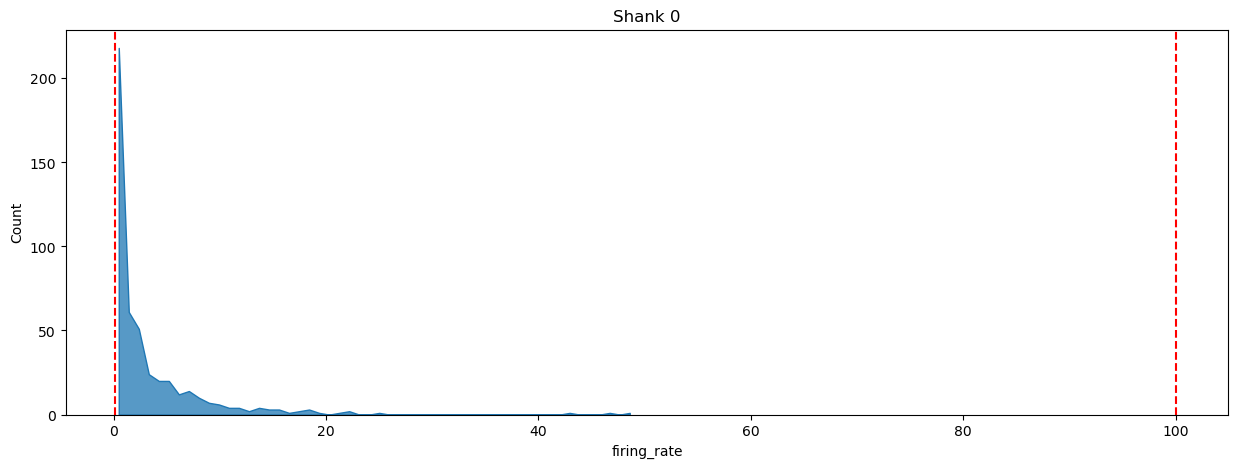

In [74]:
# Initialize figure
fig, axs = plt.subplots(ncols=num_shanks,figsize=(15, 5))

# Loop through all shanks
if num_shanks > 1:
    for shank in range(num_shanks):
        sns.histplot(data=metrics_all[shank]['firing_rate'],element="poly",ax=axs[shank])
        # axs[shank].set_xlim([0,100])
        axs[shank].axvline(firing_rate_max, color='red',linestyle='--')
        axs[shank].axvline(firing_rate_min, color='red',linestyle='--')
        axs[shank].set_title('Shank ' + str(shank))
else:
    sns.histplot(data=metrics_all[shank]['firing_rate'],element="poly")
    # axs[shank].set_xlim([0,100])
    axs.axvline(firing_rate_max, color='red',linestyle='--')
    axs.axvline(firing_rate_min, color='red',linestyle='--')
    axs.set_title('Shank ' + str(shank))
    
plt.savefig(session_sorting_path / 'firing_rate.png')

#### Distribution of presence_ratio

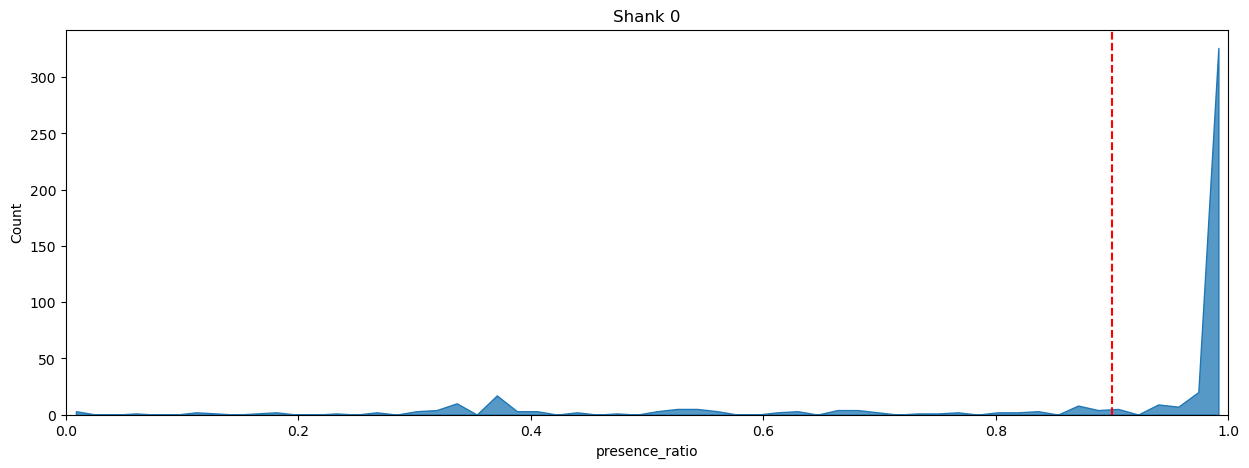

In [69]:
# Initialize figure
fig, axs = plt.subplots(ncols=num_shanks,figsize=(15, 5))

# Loop through all shanks
if num_shanks > 1:
    for shank in range(num_shanks):
        sns.histplot(data=metrics_all[shank]['presence_ratio'],element="poly",ax=axs[shank])
        axs[shank].set_xlim([0,1])
        axs[shank].axvline(presence_ratio_thresh, color='red',linestyle='--')
        axs[shank].set_title('Shank ' + str(shank))
else:
    sns.histplot(data=metrics_all[shank]['presence_ratio'],element="poly",ax=axs)
    axs.set_xlim([0,1])
    axs.axvline(presence_ratio_thresh, color='red',linestyle='--')
    axs.set_title('Shank ' + str(shank))
    
plt.savefig(session_sorting_path / 'presence_ratio.png')

#### Distribution of SNR

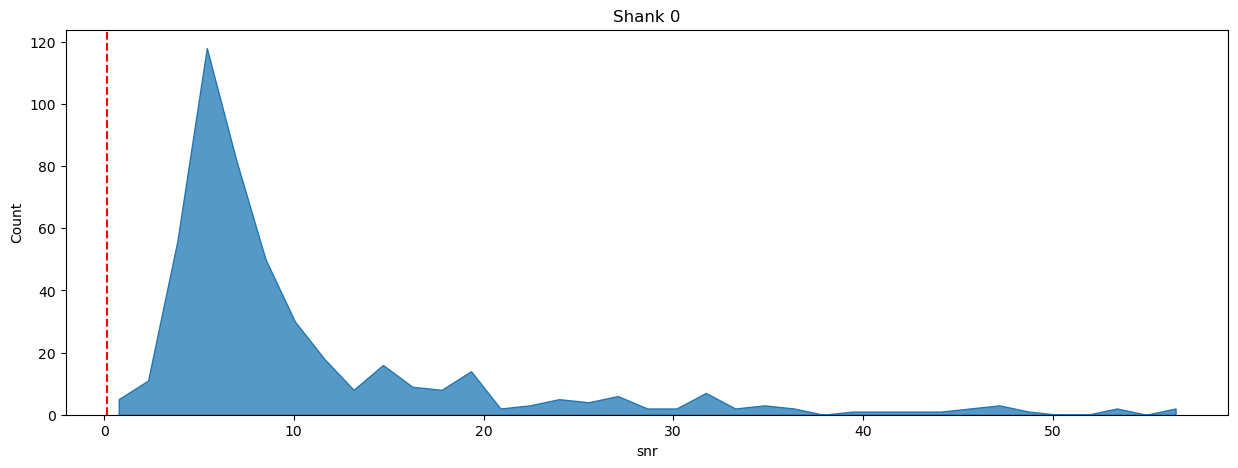

In [71]:
# Initialize figure
fig, axs = plt.subplots(ncols=num_shanks,figsize=(15, 5))

# Loop through all shanks
if num_shanks > 1:
    for shank in range(num_shanks):
        sns.histplot(data=metrics_all[shank]['snr'],element="poly",ax=axs[shank])
        # axs[shank].set_xlim([0,1])
        # axs[shank].axvline(amplitude_cutoff_thresh, color='red',linestyle='--')
        axs[shank].set_title('Shank ' + str(shank))
else:
    sns.histplot(data=metrics_all[shank]['snr'],element="poly",ax=axs)
    # axs.set_xlim([0,1])
    axs.axvline(amplitude_cutoff_thresh, color='red',linestyle='--')
    axs.set_title('Shank ' + str(shank)) 
    
plt.savefig(session_sorting_path / 'snr.png')

#### Distribution of ISI_violations

- Threshold for classifying adjacent spikes as an ISI violation is set at 1.5 ms. This is the biophysical refractory period.
- You can interpret an ISI violations ratio value of 0.5 as meaning that contaminating spikes are occurring at roughly half the rate of “true” spikes for that unit. In cases of highly contaminated units, the ISI violations ratio can sometimes be greater than 1.

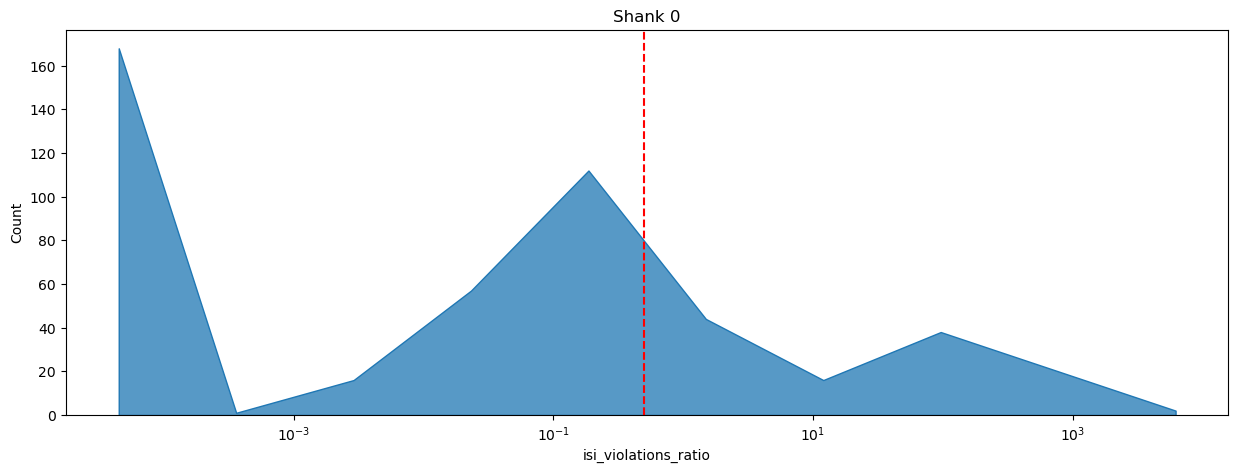

In [72]:
# Initialize figure
fig, axs = plt.subplots(ncols=num_shanks,figsize=(15, 5))

# Loop through all shanks
if num_shanks > 1:
    for shank in range(num_shanks):
        sns.histplot(data=metrics_all[shank]['isi_violations_ratio']+0.00001,element="poly",log_scale=True,ax=axs[shank])
        axs[shank].axvline(isi_violations_ratio_thresh, color='red',linestyle='--')
        # axs[shank].set_xlim([0,1])
        axs[shank].set_title('Shank ' + str(shank))
else:
    sns.histplot(data=metrics_all[shank]['isi_violations_ratio']+0.00001,element="poly",log_scale=True,ax=axs)
    axs.axvline(isi_violations_ratio_thresh, color='red',linestyle='--')
    # axs.set_xlim([0,1])
    axs.set_title('Shank ' + str(shank))
    
plt.savefig(session_sorting_path / 'isi_violations.png')

#### Distribution of amplitude cutoff

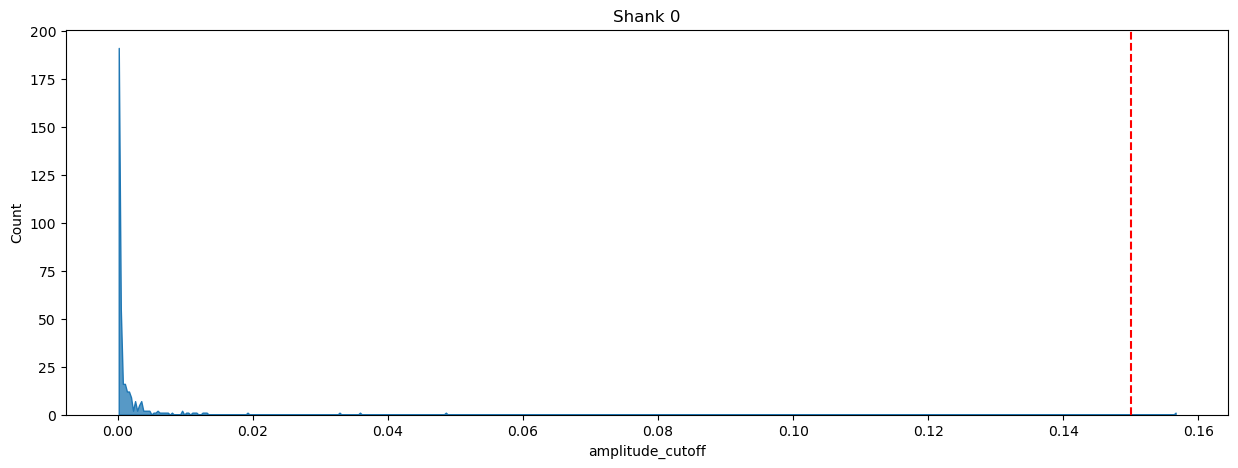

In [73]:
# Initialize figure
fig, axs = plt.subplots(ncols=num_shanks,figsize=(15, 5))

# Loop through all shanks
if num_shanks > 1:
    for shank in range(num_shanks):
        sns.histplot(data=metrics_all[shank]['amplitude_cutoff'],element="poly",ax=axs[shank])
        axs[shank].axvline(amplitude_cutoff_thresh, color='red',linestyle='--')
        # axs[shank].set_xlim([0,1])
        axs[shank].set_title('Shank ' + str(shank))
else:
    sns.histplot(data=metrics_all[shank]['amplitude_cutoff'],element="poly",ax=axs)
    axs.axvline(amplitude_cutoff_thresh, color='red',linestyle='--')
    # axs.set_xlim([0,1])
    axs.set_title('Shank ' + str(shank))
    
plt.savefig(session_sorting_path / 'amplitude_cutoff.png')

### For one shank

In [11]:
shank = 2
shank_wf_path = session_sorting_path / str(shank) / 'waveforms_kilosort2_5'
we = si.load_waveforms(shank_wf_path)

In [24]:
# metrics = si.compute_quality_metrics(we, metric_names=['firing_rate', 'presence_ratio', 'snr',
#                                                        'isi_violation', 'amplitude_cutoff',
#                                                        'isolation_distance', 'l_ratio', 'd_prime',])
# metrics

# Load metrics from folder
metrics = pd.read_csv(shank_wf_path / 'quality_metrics' / 'metrics.csv', index_col=0)
metrics

,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,amplitude_cutoff
0,0.481688,0.906977,3.076122,140.944748,255,0.006043
1,0.900279,1.000000,4.515860,1.898746,12,0.001729
2,1.745926,0.441860,1.905434,36.518095,868,0.118362
3,0.058095,0.325581,2.573576,493.977118,13,NaN
4,0.039243,0.697674,5.236270,666.203665,8,NaN
...,...,...,...,...,...,...
118,1.175365,1.000000,3.490215,35.554430,383,0.000441
119,12.080285,1.000000,4.666124,0.020212,23,0.000076
120,0.370500,0.441860,16.070713,110.241930,118,0.025270
121,0.262004,0.837209,3.842140,136.378532,73,0.003885


#### Export final results to disk folder and visulize with sortingview

In order to export the final results we need to make a copy of the the waveforms, but only for the selected units (so we can avoid to compute them again).

In [39]:
we_clean = si.load_waveforms(base_folder / 'waveforms_clean')
we_clean

WaveformExtractor: 384 channels - 25 units - 1 segments
  before:45 after:60 n_per_units:500 - sparse

In [ ]:
# push the results to sortingview webased viewer
# si.plot_sorting_summary(we_clean, backend='sortingview')

## Compare with multiple sorters

With 3 or more spike sorters, the comparison is implemented with a graph-based method. The multiple sorter comparison also allows to clean the output by applying a consensus-based method which only selects spike trains and spikes in agreement with multiple sorters.

Comparison of multiple sorters uses the following procedure:

1. Perform pairwise symmetric comparisons between spike sorters
2. Construct a graph in which nodes are units and edges are the agreements between units (of different sorters)
3. Extract units in agreement between two or more spike sorters
4. Build agreement spike trains, which only contain the spikes in agreement for the comparison with the highest agreement score

In [ ]:

# Compare multiple spike sorter outputs
mcmp = sc.compare_multiple_sorters(
    sorting_list=[sorting_MS4, sorting_HS, sorting_TDC],
    name_list=['MS4', 'HS', 'TDC'],
    verbose=True,
)

# The multiple sorters comparison internally computes pairwise comparison,
# that can be accessed as follows:
print(mcmp.comparisons[('MS4', 'HS')].sorting1, mcmp.comparisons[('MS4', 'HS')].sorting2)
print(mcmp.comparisons[('MS4', 'HS')].get_matching())

print(mcmp.comparisons[('MS4', 'TDC')].sorting1, mcmp.comparisons[('MS4', 'TDC')].sorting2)
print(mcmp.comparisons[('MS4', 'TDC')].get_matching())

# The global multi comparison can be visualized with this graph
sw.plot_multicomp_graph(mcmp)

# Consensus-based method
#
# We can pull the units in agreement with different sorters using the
# :py:func:`~spikeinterface.comparison.MultiSortingComparison.get_agreement_sorting` method.
# This allows to make spike sorting more robust by integrating the output of several algorithms.
# On the other hand, it might suffer from weak performance of single algorithms.
# When extracting the units in agreement, the spike trains are modified so
# that only the true positive spikes between the comparison with the best
# match are used.

agr_3 = mcmp.get_agreement_sorting(minimum_agreement_count=3)
print('Units in agreement for all three sorters: ', agr_3.get_unit_ids())

agr_2 = mcmp.get_agreement_sorting(minimum_agreement_count=2)
print('Units in agreement for at least two sorters: ', agr_2.get_unit_ids())

agr_all = mcmp.get_agreement_sorting()

# The unit index of the different sorters can also be retrieved from the
# agreement sorting object (:code:`agr_3`) property :code:`sorter_unit_ids`.

print(agr_3.get_property('unit_ids'))

print(agr_3.get_unit_ids())
# take one unit in agreement
unit_id0 = agr_3.get_unit_ids()[0]
sorter_unit_ids = agr_3.get_property('unit_ids')[0]
print(unit_id0, ':', sorter_unit_ids)